In [1]:
# uploading the important libraries and functions that will be used in the analysis 
config = {}
config = {'basedir': '/Volumes/MacBack/GenzelLab/VitorCode/QinnonThetaFreq/dlt2/aquinn/ThetaShapeExample/data_dist',
          'figdir': None,
          'datadir': None,
          'analysisdir': '/Volumes/MacBack/GenzelLab/VitorCode/QinnonThetaFreq/dlt2/aquinn/ThetaShapeExample/data_dist'}
config['1col_width'] = 85
config['2col_width'] = 114
config['3col_width'] = 174
config['fontname'] = 'Helvetica'

config['recordings'] = ['mdm81-2311-0128_2',
                        'mdm81-2311-0128_5',
                        'mdm90-1901-0127_2',
                        'mdm90-1901-0127_5',
                        'mdm96-1806-0121_2',
                        'mdm96-1806-0121_6']

config['tetrode_inds'] = [25, 25, 9, 9, 33, 33]


import emd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal, stats, ndimage
from scipy import ndimage, interpolate
import sails
import h5py
import logging 
import pandas as pd
import glmtools as glm
from scipy import stats
from matplotlib.colors import ListedColormap
import scipy.io
matplotlib.rc('font', serif=config['fontname'])



def my_range(x):
    return x.max() - x.min()

def compute_range(x):
    return x.max() - x.min()


def asc2desc(x):
    """Ascending to Descending ratio ( A / A+D )."""
    pt = emd.cycles.cf_peak_sample(x, interp=True)
    tt = emd.cycles.cf_trough_sample(x, interp=True)
    if (pt is None) or (tt is None):
        return np.nan
    asc = pt + (len(x) - tt)
    desc = tt - pt
    return asc / len(x)

def peak2trough(x):
    """Peak to trough ratio ( P / P+T )."""
    des = emd.cycles.cf_descending_zero_sample(x, interp=True)
    if des is None:
        return np.nan
    return des / len(x)

def decorate_ax(ax):
    for tag in ['top', 'right']:
        ax.spines[tag].set_visible(False)
        
def load_tracking(whl_path, new_len, smoothing=1):
    """Load position data from .whl file"""
    track = np.genfromtxt( whl_path )
    track[track<0] = np.nan
    if smoothing is not None:
            track = ndimage.filters.gaussian_filter1d(track, smoothing, axis=0)

    pixels2bins = 37 / (np.nanmax(track[:,0])-np.nanmin(track[:,0])) * 1/32. * 1250
    velx = np.gradient(track[:,0])
    vely = np.gradient(track[:,1])
    speed = np.sqrt(pow(velx,2)+pow(vely,2))

    # Upsample to match LFP data
    factor = 1250/32
    f = interpolate.interp1d( np.linspace(0,track.shape[0]/factor,track.shape[0]), speed,
                       kind='nearest', bounds_error=False)
    big_speed= f( np.linspace(0,new_len/1250, new_len) )*pixels2bins

    return big_speed

def load_dataset(run_id):
    logger = logging.getLogger('emd')

    inds = np.where([r == run_id for r in config['recordings']])[0][0]
    fileName = config['recordings'][inds]+'.eeg'
    logger.info('Loading data from: {0}'.format(fileName))
    raw = np.fromfile(fileName, dtype=np.int16).astype(float)
    raw = raw.reshape(-1,64)[:,config['tetrode_inds'][inds]]
    sample_rate = 1250
    seconds = raw.shape[0] / sample_rate
    time = np.linspace(0,seconds,raw.shape[0])
    logger.info('Loaded {0} seconds of data'.format(seconds))
    fileWhl = config['recordings'][inds]+'.whl'
    logger.info('Loading tracking from: {0}'.format(fileWhl))
    speed = load_tracking(fileWhl, time.shape[0], smoothing=16)

    return raw, speed, time, sample_rate

def getIMFmainfreq(If, Ia):
    '''
    If the instantaneous frequency extracted from imfs
    Ia instantenous amplitude 
    '''
    IF = If.transpose()
    IA = Ia.transpose()

    nimfs = np.size(IA,0)

    mainfreqs = np.zeros(nimfs)+np.nan
    for imfi in range(0,nimfs):
        if0 = np.copy(IF[imfi,1:-1])
        ia0 = np.copy(IA[imfi,1:-1])
        mainfreqs[imfi] = np.sum(if0*pow(ia0,2))/np.sum(pow(ia0,2))
    return mainfreqs


def remove_frames(ax, tags=['top', 'right']):
    for tag in tags:
        ax.spines[tag].set_visible(False)

def decorate(ax, mode='timex', bottom_row=True):
    for tag in ['top', 'right']:
        ax.spines[tag].set_visible(False)
    if mode == 'phasex':
        if bottom_row:
            xlabels = ['-pi', '-pi/2', '0', 'pi/2', 'pi']
            ax.set_xlabel('Theta Phase (rads)')
        else:
            xlabels = []
        ax.set_xticks(np.linspace(0, 48, 5))
        ax.set_xticklabels(xlabels)
    elif mode == 'timex':
        if bottom_row:
            xlabels = np.arange(5)*50
            ax.set_xlabel('Time (samples)')
        else:
            xlabels = []
        ax.set_xticks(np.arange(5)*50)
        ax.set_xticklabels(xlabels)
    elif mode == 'normx':
        if bottom_row:
            xlabels = np.linspace(0, 1, 3)
            ax.set_xlabel('Proportion of sinusoid')
        else:
            xlabels = []
        ax.set_xticks(np.linspace(0, 48, 3))
        ax.set_xticklabels(xlabels)

def shift_ax(ax, shift):
    pos = list(ax.get_position().bounds)
    pos[0] = pos[0] + shift
    ax.set_position(pos)

def phase_from_freq(ifrequency, sample_rate, phase_start=-np.pi):
    """
    Compute the instantaneous phase of a signal from its instantaneous phase.
    Parameters
    ----------
    ifrequency : ndarray
        Input array containing the instantaneous frequencies of a signal
    sample_rate : scalar
        The sampling frequency of the data
    phase_start : scalar
         Start value of the phase output (Default value = -np.pi)
    Returns
    -------
    IP : ndarray
        The instantaneous phase of the signal
    """

    iphase_diff = (ifrequency / sample_rate) * (2 * np.pi)

    iphase = phase_start + np.cumsum(iphase_diff, axis=0)

    iphase = np.r_[phase_start, iphase]

    return iphase

def get_cycle_examples():
    from scipy import interpolate
    freq = 8
    seconds = 2/freq
    num_samples = 3124

    time_vect = np.linspace(0, seconds, num_samples)

    phs = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
    tim2 = [0, 390-100, 781, 1171+100, 1562]
    tim3 = [0, 390+100, 781, 1171-100, 1562]
    tim4 = [0, 390-150, 781, 1171+150, 1562]

    pin2 = interpolate.interp1d(tim2, phs, kind='quadratic')
    pin3 = interpolate.interp1d(tim3, phs, kind='quadratic')
    pin4 = interpolate.interp1d(tim4, phs, kind='quadratic')

    xx2 = pin2(np.arange(1562))
    xx3 = pin3(np.arange(1562))
    xx4 = pin4(np.arange(1562))

    x = np.zeros((3124, 5))
    x[:, 0] = -np.cos(2*np.pi*8*time_vect)
    x[:, 1] = np.r_[np.sin(xx4), np.sin(xx4), np.sin(xx4)][1171:1171+3124]
    x[:, 2] = np.flipud(x[:, 1])
    x[:, 3] = -np.r_[np.cos(xx2), np.cos(xx2)]
    x[:, 4] = -np.r_[np.cos(xx3), np.cos(xx3)]
    return time_vect, x

def add_circles(ax, waves=False, sines=False,
                wave_len=.5, wave_height=1, offset=3):

    x_polar = np.linspace(0, 2*np.pi, 128)
    factor = np.array([.5, 1])*2
    for f in factor:
        ax.plot(f*np.sin(x_polar), f*np.cos(x_polar), 'k', linewidth=.75)
    ax.plot((-2.5, 2.5), (0, 0), 'k', linewidth=.75)
    ax.plot((0, 0), (-2.5, 2.5), 'k', linewidth=.75)
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-3.5, 3.5)
    ax.set_xticks([])
    ax.set_yticks([])

    tv, canonical_cycles = get_cycle_examples()
    canonical_cycles = canonical_cycles*wave_height
    tv /= 15
    tv2 = np.linspace(0, wave_len, 3124)

    if sines:
        ax.plot(tv2-wave_len/2, canonical_cycles[:, 0]-offset, 'k', linewidth=.5)
        ax.plot(tv2-wave_len/2, canonical_cycles[:, 0]+offset, 'k', linewidth=.5)
        ax.plot(tv2-offset-wave_len/2, canonical_cycles[:, 0], 'k', linewidth=.5)
        ax.plot(tv2+offset-wave_len/2, canonical_cycles[:, 0], 'k', linewidth=.5)

    if waves:
        ax.plot(tv2-wave_len/2, canonical_cycles[:, 3]-offset, 'k')
        ax.plot(tv2-wave_len/2, canonical_cycles[:, 4]+offset, 'k')
        ax.plot(tv2-offset-wave_len/2, canonical_cycles[:, 2], 'k')
        ax.plot(tv2+offset-wave_len/2, canonical_cycles[:, 1], 'k')
        

def normalised_waveform(infreq, sample_rate):
    sr = infreq.mean() * len(infreq)
    phase_diff = (infreq / sr) * (2 * np.pi)
    phase = np.cumsum(phase_diff, axis=0)
    phase = np.r_[0, phase]
    sine = np.sin(np.linspace(0, 2*np.pi, len(phase)))
    nw = np.sin(phase)

    return nw, sine

def scatter_kde(x, y):
    # Calculate the point density
    xy = np.vstack([x, y])
    z = stats.gaussian_kde(xy)(xy)

    # KDE colouring
    plt.scatter(x, y, c=z, s=5, edgecolor=['none'])






(241313,)
Procced


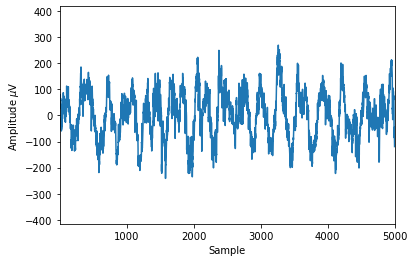

In [3]:
# Loading the REM data sent by Julien as an example to establish the method 
from utils import find_REM, load_data
REM_files = find_REM()

rem = REM_files[0]
dataREM = load_data(rem)
lfpREM = dataREM[0]

print(lfpREM.shape)

# Now plotting the data to inspect them
plt.plot(lfpREM)
plt.xlim((1,5000))
plt.xlabel('Sample')
plt.ylabel('Amplitude $\mu$V')
print('Procced')

(5.0, 10.0)

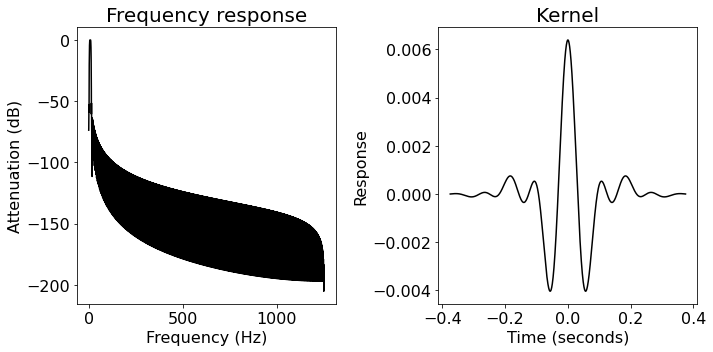

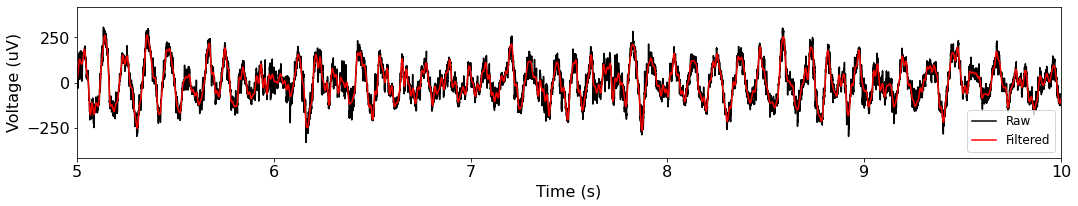

In [4]:
from neurodsp.filt import filter_signal
from neurodsp.plts import plot_time_series

# Filter settings
f_theta = (4, 12)
f_lowpass = 25
n_seconds_filter = .5  # could be changed to 0.1
n_seconds_theta = .75
fs = 2500

#Filtering the signal
sig_low = filter_signal(lfpREM, 1000, 'lowpass', f_lowpass, n_seconds=n_seconds_filter, remove_edges=False)
sig_filt = filter_signal(lfpREM, fs, 'bandpass', f_theta, n_seconds=.75, plot_properties=True, remove_edges=False)

times = np.arange(0, len(lfpREM)/fs, 1/fs)

theta = sig_low

plot_time_series(times, [lfpREM, theta], ['Raw', 'Filtered'])
plt.xlim(5, 10)


In [5]:
sample_rate = 2500
IP, IF, IA = emd.spectra.frequency_transform(theta, sample_rate, 'hilbert', smooth_phase=3)
IP.shape

(241313, 1)

In [6]:
C = emd.cycles.Cycles(IP.flatten())
display(C)

<class 'emd.cycles.Cycles'> (1191 cycles 1 metrics) 

In [7]:
# computing the cycle metrics 
C.compute_cycle_metric('start_sample', np.arange(len(C.cycle_vect)), emd.cycles.cf_start_value)
C.compute_cycle_metric('stop_sample', theta, emd.cycles.cf_end_value)
C.compute_cycle_metric('peak_sample', theta, emd.cycles.cf_peak_sample)
C.compute_cycle_metric('desc_sample', theta, emd.cycles.cf_descending_zero_sample)
C.compute_cycle_metric('trough_sample', theta, emd.cycles.cf_trough_sample)
C.compute_cycle_metric('duration_samples', theta, len)

C.compute_cycle_metric('max_amp', IA, np.max)
C.compute_cycle_metric('mean_if', IF, np.mean)
C.compute_cycle_metric('max_if', IF, np.max)
C.compute_cycle_metric('range_if', IF, compute_range)

C.compute_cycle_metric('asc2desc', theta, asc2desc)
C.compute_cycle_metric('peak2trough', theta, peak2trough)

print('Finished computing the cycles metrics')

Finished computing the cycles metrics


In [8]:
display(C)

<class 'emd.cycles.Cycles'> (1191 cycles 13 metrics) 

In [9]:
# Extract subset of the cycles 
amp_thresh = np.percentile(IA, 25)
lo_freq_duration = sample_rate/5
hi_freq_duration = sample_rate/12
conditions = ['is_good==1',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'max_amp>{amp_thresh}']

C.pick_cycle_subset(conditions)

In [10]:
display(C)

<class 'emd.cycles.Cycles'> (1191 cycles 52 subset 50 chains - 14 metrics) 

In [65]:
df = C.get_metric_dataframe(conditions=conditions)
# phase-aligned waveforms
pa, phasex = emd.cycles.phase_align(IP, IF, C.iterate(through='subset'))
# Compute normalised waveforms
norm_waveform, sine = emd.cycles.normalised_waveform(pa)

# phase-aligned waveforms
pa, phasex = emd.cycles.phase_align(IP, IF, C.iterate(through='subset'))
# Compute normalised waveforms
norm_waveform, sine = emd.cycles.normalised_waveform(pa)
# ZC-aligned waveforms
zc_waveform = np.zeros((313, pa.shape[1]))*np.nan
zc_instfreq = np.zeros((313, pa.shape[1]))*np.nan
for ii, inds in C.iterate(through='subset'):
    zc_waveform[:len(inds), ii] = theta[inds]
    zc_instfreq[:len(inds), ii] = IF[inds]


 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'


ValueError: could not broadcast input array from shape (226,1) into shape (226,)

In [61]:
np.expand_dims(theta, axis=1).shape

(241313, 1)

In [12]:
# starting with some plotting and inspection of the results 
edges, bins = emd.spectra.define_hist_bins(2, 128, 128, 'log')

plot_inds = np.arange(7500+1000, 7500+1000+4*1000)

TINY_SIZE = 6
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TINY_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TINY_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

frames = True

In [18]:
np.gradient(ip)

ValueError: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.

 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'


/home/miranjo/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/miranjo/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


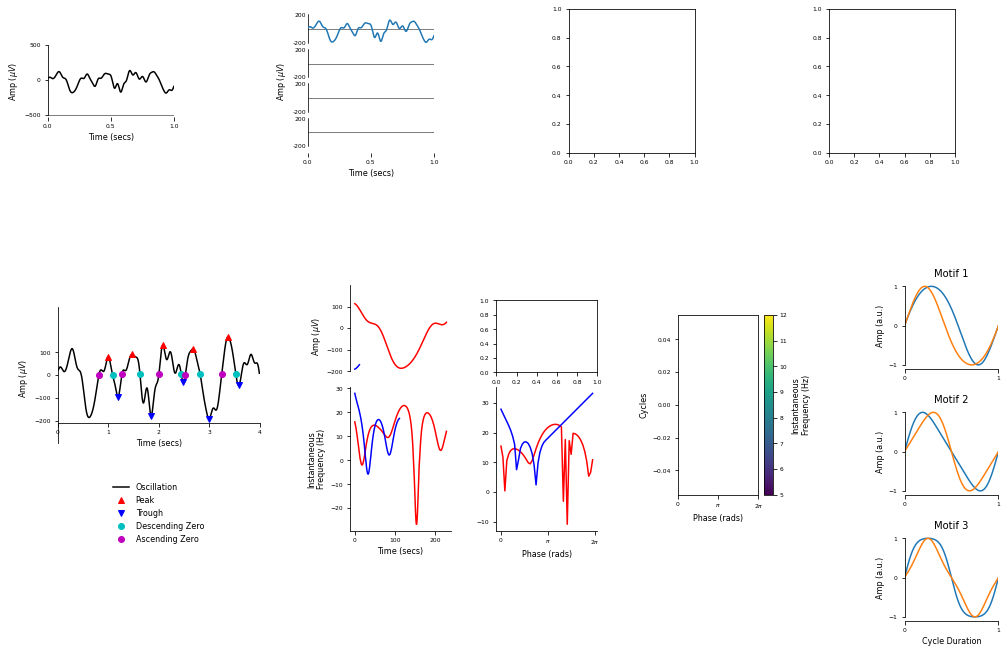

In [66]:
# plot 1
start = 1000
inds = np.arange(start, start+1000*1).astype(int)
tt = np.linspace(0, 1, len(inds))

plt.figure(figsize=(14, 10))
ax1 = plt.axes([0.05, .775, .125, .1], frameon=frames)
ax2 = plt.axes([.308, .725, .125, .2], frameon=frames)
ax3 = plt.axes([.5666, .725, .125, .2], frameon=frames)
ax4 = plt.axes([.825, .725, .125, .2], frameon=frames)
ax5 = plt.axes([.06, .35, .2, .125], frameon=frames)


ax1.plot(tt, theta[inds], 'k')
ax1.plot(tt, np.zeros_like(tt)-500, 'k', linewidth=0.5)
remove_frames(ax1, tags=['top', 'right', 'bottom'])
ax1.set_xlim(tt[0], tt[-1])
ax1.set_xticks([0, 0.5, 1])
ax1.set_xlabel('Time (secs)')
ax1.set_ylabel(r'Amp ($\mu V$)')
ax1.spines['left'].set_bounds(-500, 500)
ax1.set_yticks([-500, 0, 500])

remove_frames(ax2, tags=['top', 'right', 'bottom', 'left'])

ax2.set_xlim(tt[0], tt[-1])
ax2.set_xticks([0, 0.5, 1])
for ii in range(4):
    ax2.plot(tt, np.zeros_like(tt)-ii*500, 'k', linewidth=0.5)
    ax2.plot((0, 0), (-200-ii*500, 200-ii*500), 'k')
    ax2.text(-.015, 200-ii*500, '200', va='center', ha='right', fontsize=TINY_SIZE)
    ax2.text(-.015, -200-ii*500, '-200', va='center', ha='right', fontsize=TINY_SIZE)
ax2.set_yticks([])

ax2.plot(tt, theta[inds])

ax2.set_ylabel(r'Amp ($\mu V$)', labelpad=20)
ax2.set_xlabel('Time (secs)')

#ip = IP[inds]
#ip[np.gradient(ip) < -2] =  np.nan
#remove_frames(ax3, tags=['top', 'right', 'left'])
#ax3.set_yticks([])
#ax3.plot(tt, ip)
#ax3.set_xlim(tt[0], tt[-1])
#ax3.set_xticks([0, 0.5, 1])
#ax3.set_xlabel('Time (secs)')
#ax3.plot(tt, IF[inds]-14)
#ax3.plot((0, 0), (0, np.pi*2), 'k')
#ax3.plot((0, 0), (4-14, 10-14), 'k')
#ax3.text(-.015, np.pi*2, r'2$\pi$', va='center', ha='right', fontsize=TINY_SIZE)
#ax3.text(-.015, 0, r'0', va='center', ha='right', fontsize=TINY_SIZE)
#ax3.text(-.015, 10-14, '10', va='center', ha='right', fontsize=TINY_SIZE)
#ax3.text(-.015, 7-14, '7', va='center', ha='right', fontsize=TINY_SIZE)
#ax3.text(-.015, 4-14, '4', va='center', ha='right', fontsize=TINY_SIZE)
#ax3.text(-.1, 7-14, 'Instantaneous\nFrequency (Hz)', va='center', ha='right', fontsize=SMALL_SIZE, rotation=90)
#ax3.text(-.1, np.pi, 'Instantaneous\nPhase (rads)', va='center', ha='right', fontsize=SMALL_SIZE, rotation=90)

inds = np.arange(start, start+1250*1).astype(int)
tt = np.linspace(0, 4, len(inds))
Cex = emd.cycles.Cycles(IP[inds], compute_timings=True)
Cex.compute_cycle_metric('peak', theta[inds], emd.cycles.cf_peak_sample)
Cex.compute_cycle_metric('desc', theta[inds], emd.cycles.cf_descending_zero_sample)
Cex.compute_cycle_metric('trough', theta[inds], emd.cycles.cf_trough_sample)
df_abs = Cex.get_metric_dataframe()


ax5.plot(theta[inds], 'k')
for ii in range(1, len(df_abs)-1):
    st = df_abs['start_sample'].values[ii]
    pk = st +  df_abs['peak'].values[ii]
    ax5.plot(pk, theta[inds[int(pk)]], '^r')
    tr = st +  df_abs['trough'].values[ii]
    ax5.plot(tr, theta[inds[int(tr)]], 'vb')
    asc = st +  df_abs['desc'].values[ii]
    ax5.plot(asc, theta[inds[int(asc)]], 'oc')
    desc = st
    ax5.plot(desc, theta[inds[int(desc)]], 'om')
    if ii == 1:
        plt.legend(['Oscillation', 'Peak', 'Trough', 'Descending Zero', 'Ascending Zero'], frameon=False, bbox_to_anchor=(0.5, -1), loc='center')
remove_frames(ax5, tags=['top', 'right'])
ax5.set_xlim(tt[0], tt[-1])
ax5.set_xticks(np.linspace(0, len(tt), 5))
ax5.set_xticklabels(np.arange(5))
ax5.set_xlabel('Time (secs)')
ax5.set_ylabel(r'Amp ($\mu V$)')
ax5.spines['left'].set_bounds(-300, 300)


ax6 = plt.axes([0.35, 0.42, 0.1, 0.1])
ax7 = plt.axes([0.35, 0.2, 0.1, 0.2])
ax8 = plt.axes([0.495, 0.42, 0.1, 0.1])
ax9 = plt.axes([0.495, 0.2, 0.1, 0.2])

pa = emd.cycles.phase_align(IP[inds], IF[inds], cycles=Cex)

cind = (2, 6)

ax6.plot(theta[inds[C._slice_cache[cind[0]]]], 'r')
ax6.plot(theta[inds[C._slice_cache[cind[1]]]], 'b')
remove_frames(ax6, tags=['top', 'right', 'bottom'])
ax6.set_ylabel(r'Amp ($\mu V$)')
ax6.set_xticks([])
ax6.spines['left'].set_bounds(-200, 200)

ax7.plot(IF[inds[Cex._slice_cache[cind[0]]]], 'r')
ax7.plot(IF[inds[Cex._slice_cache[cind[1]]]], 'b')
remove_frames(ax7, tags=['top', 'right'])
ax7.set_xlabel('Time (secs)')
ax7.set_ylabel('Instantaneous\nFrequency (Hz)', rotation=90, fontsize=SMALL_SIZE)

ax9.plot(pa[0][:, cind[0]], 'r')
ax9.plot(pa[0][:, cind[1]], 'b')
remove_frames(ax9, tags=['top', 'right'])
ax9.set_xlabel('Phase (rads)')
ax9.set_xticks(np.linspace(0, 48, 3))
ax9.set_xticklabels(['0', r'$\pi$', r'2$\pi$'])

inds = np.arange(start, start+1250*12).astype(int)
Cex2 = emd.cycles.Cycles(IP[inds], compute_timings=True)
pa, _ = emd.cycles.phase_align(IP[inds], IF[inds], cycles=Cex2)
pa = pa[:, np.isfinite(pa.mean(axis=0))]
goods = np.logical_and((pa.min(axis=0) > 3), (pa.mean(axis=0) <10))

ax10 = plt.axes([0.675, 0.25, .1, .25])
im = ax10.pcolormesh(pa[:, goods].T, vmin=5, vmax=12)
cb = plt.colorbar(im)
cb.set_label('Instantaneous\nFrequency (Hz)')
ax10.set_xlabel('Phase (rads)')
ax10.set_xticks(np.linspace(0, 48, 3))
ax10.set_xticklabels(['0', r'$\pi$', r'2$\pi$'])
ax10.set_ylabel('Cycles')

ax11 = plt.axes([0.9, 0.425, 0.093, 0.12])
ax12 = plt.axes([0.9, 0.25, 0.093, 0.12])
ax13 = plt.axes([0.9, 0.075, 0.093, 0.12])


samples_per_cycle = 480
ncycles = 6
ph = np.linspace(0, np.pi*2*ncycles, samples_per_cycle*ncycles)
t = np.linspace(0, ncycles, samples_per_cycle*ncycles)
basis = np.c_[np.zeros_like(ph),
              0.9*np.cos(2*np.pi*1*t)[:, None],
              -0.9*np.cos(2*np.pi*1*t)[:, None],
              1.55*np.sin(2*np.pi*1*t)[:, None],
              -1.55*np.sin(2*np.pi*1*t)[:, None],
              np.sin(2*np.pi*2*t)[:, None],
              -0.8*np.sin(2*np.pi*2*t)[:, None]]
basis = basis * 1/4

phs = ph[:, None] + basis

X = np.sin(phs)
IP2, IF2, IA2 = emd.spectra.frequency_transform(X, samples_per_cycle, 'hilbert')

cycles = emd.cycles.get_cycle_vector(IP2, return_good=True)

lin_inds = cycles[:, 0] == 1
inds = cycles[:, 1] == 2
ax11.plot(np.linspace(0, 1, inds.sum()), np.sin(phs[inds, 1]))
inds = cycles[:, 2] == 2
ax11.plot(np.linspace(0, 1, inds.sum()), np.sin(phs[inds, 2]))
remove_frames(ax11, tags=['top', 'right'])
ax11.set_yticks([-1, 0, 1])
ax11.set_ylabel('Amp (a.u.)')
ax11.set_xlim(0, 1)
ax11.set_xticks([0, 1])
ax11.set_title('Motif 1', fontsize=MEDIUM_SIZE)
ax11.spines['left'].set_bounds(-1, 1)


inds = cycles[:, 3] == 2
ax12.plot(np.linspace(0, 1, inds.sum()), np.sin(phs[inds, 3]))
inds = cycles[:, 4] == 2
ax12.plot(np.linspace(0, 1, inds.sum()), np.sin(phs[inds, 4]))
remove_frames(ax12, tags=['top', 'right'])
ax12.set_yticks([-1, 0, 1])
ax12.set_xlim(0, 1)
ax12.set_ylabel('Amp (a.u.)')
ax12.set_xticks([0, 1])
ax12.set_title('Motif 2', fontsize=MEDIUM_SIZE)
ax12.spines['left'].set_bounds(-1, 1)


inds = cycles[:, 5] == 2
ax13.plot(np.linspace(0, 1, inds.sum()), np.sin(phs[inds, 5]))
inds = cycles[:, 6] == 2
ax13.plot(np.linspace(0, 1, inds.sum()), np.sin(phs[inds, 6]))
remove_frames(ax13, tags=['top', 'right'])
ax13.set_xlabel('Cycle Duration', fontsize=SMALL_SIZE)
ax13.set_yticks([-1, 0, 1])
ax13.set_ylabel('Amp (a.u.)')
ax13.set_xlim(0, 1)
ax13.set_xticks([0, 1])
ax13.set_title('Motif 3', fontsize=MEDIUM_SIZE)
ax13.spines['left'].set_bounds(-1, 1)


In [41]:
display(df_abs)
pa.shape

,is_good,start_sample,stop_sample,duration,peak,desc,trough
0,0,0,253,254,87.646047,145.207207,192.728007
1,0,254,396,143,57.946980,85.191191,118.370767
2,0,397,625,229,62.487380,112.354354,181.388079
3,0,626,789,164,24.428398,139.726727,152.088123
4,1,790,1015,226,47.267080,92.943944,146.990881
5,1,1016,1137,122,38.731815,87.718719,104.495563
6,0,1138,1249,112,59.430519,None,32.950874


(48, 63)

In [ ]:
# Not used since filtered theta signal is only one component
# combining the methods 
imfnew = imf[:,2]+imf[:,3]

plt.plot(imfnew)

plt.xlim((230000,231000))

start = 1000

inds = np.arange(start, start+1000*1).astype(int)
tt = np.linspace(0, 1, len(inds))
IP_n, IF_n, IA_n = emd.spectra.frequency_transform(imfnew, sample_rate, 'hilbert', smooth_phase=3)

inds = np.arange(start, start+1000*1).astype(int)
tt = np.linspace(0, 4, len(inds))
Cex = emd.cycles.Cycles(IP[inds, componentI], compute_timings=True)
Cex.compute_cycle_metric('peak', imf[inds, componentI], emd.cycles.cf_peak_sample)
Cex.compute_cycle_metric('desc', imf[inds, componentI], emd.cycles.cf_descending_zero_sample)
Cex.compute_cycle_metric('trough', imf[inds, componentI], emd.cycles.cf_trough_sample)
df_abs = Cex.get_metric_dataframe()

plt.plot(imf[inds, componentI], 'k')
for ii in range(1, len(df_abs)-1):
    st = df_abs['start_sample'].values[ii]
    pk = st +  df_abs['peak'].values[ii]
    plt.plot(pk, imf[inds[int(pk)], componentI], '^r')
    tr = st +  df_abs['trough'].values[ii]
    plt.plot(tr, imf[inds[int(tr)], componentI], 'vb')
    asc = st +  df_abs['desc'].values[ii]
    plt.plot(asc, imf[inds[int(asc)], componentI], 'oc')
    desc = st
    plt.plot(desc, imf[inds[int(desc)], componentI], 'om')
    if ii == 1:
        plt.legend(['Oscillation', 'Peak', 'Trough', 'Descending Zero', 'Ascending Zero'], frameon=False, bbox_to_anchor=(0.5, -1), loc='center')
remove_frames(ax5, tags=['top', 'right'])
plt.xlim(tt[0], tt[-1])
plt.xticks(np.linspace(0, len(tt), 5))
plt.xlabel('Time (secs)')
plt.ylabel(r'Amp ($\mu V$)')



Text(-300, -4450.0, 'Instantaneous\nFrequency\nStd-Dev')

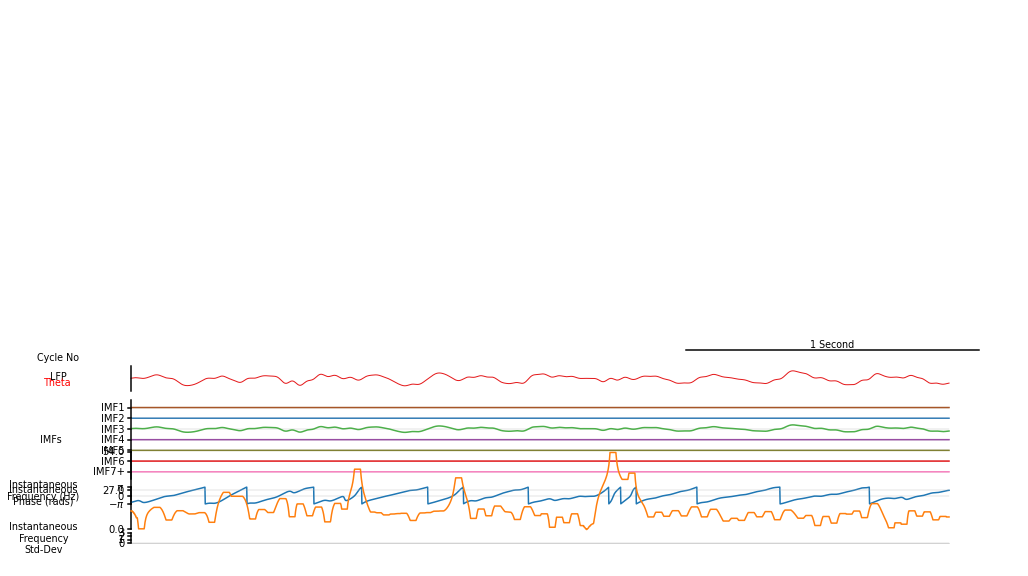

In [47]:
# creating a new figure for the analysis 
width = config['3col_width'] / 25.4
height = width * .6

plot_horiz = True
sparse_horiz = True
plot_vert = True
fontsize_side = 'large'
fontsize_tick = 10
horiz_width = .35

inds = np.arange(start, start+1000*2.8).astype(int)
cmap = plt.cm.Set1
cols = cmap(np.linspace(0, 1, 8))
cols[4, :] = [.5, .5, .2, 1]
indx = [5, 1, 2, 3, 4, 0, 6, 7]
cols = cols[indx, :]

plt.figure(figsize=(width*2, height*2))
plt.axes([.08, .025, .95, .95], frameon=False)
plt.xticks([])
plt.yticks([])


# making the plots 
plt.plot(theta[inds].sum(), color=[.2, .2, .2], linewidth=.5)
plt.plot(theta[inds], color=cols[5, :], linewidth=1)
plt.plot([0, 0], [-350, 350], 'k')
plt.text(-250, 80, 'LFP', fontsize=fontsize_side,
         verticalalignment='center', horizontalalignment='center')
plt.text(-250, 600, 'Cycle No', fontsize=fontsize_side,
         verticalalignment='center', horizontalalignment='center')
plt.text(-250, -80, 'Theta', fontsize=fontsize_side,
         verticalalignment='center', horizontalalignment='center', color='r')


plt.plot([1.9*1000, 2.9*1000], [800, 800], 'k')
plt.text(2.4*1000, 825, '1 Second', horizontalalignment='center',
         verticalalignment='bottom', fontsize=fontsize_side)

# Plot IMFs
step = -500

imf = np.zeros((len(theta), 6))
imf[:, 2] = theta

labels = ['IMF1', 'IMF2', 'IMF3', 'IMF4', 'IMF5', 'IMF6', 'IMF7+']
for ii in range(7):
    yind = -300*(1+ii)+step
    if plot_horiz:
        plt.plot([-10, len(inds)], [yind, yind], color=[.7, .7, .7], linewidth=horiz_width)
    plt.plot([-10, 0], [yind, yind], 'k')
    if ii < 6:
        plt.plot(.5*imf[inds, ii]+yind, color=cols[ii, :])
    else:
        plt.plot(.5*imf[inds, ii:].sum(axis=1)+yind, color=cols[ii, :])
    plt.text(-22, yind, labels[ii], fontsize=fontsize_tick, verticalalignment='center', horizontalalignment='right')
plt.plot([0, 0], [-2800, -600], 'k')
plt.text(-275, -300*(1+3)+step, 'IMFs', fontsize=fontsize_side, verticalalignment='center', horizontalalignment='center')

# Instantaneous Phase
labels = [r'$-\pi$', r'$0$', r'$\pi$']
for ii in range(3):
    yind = -3500+ii*75*((2*np.pi)/2)
    if sparse_horiz and ii == 1:
        plt.plot([-10, len(inds)], [yind, yind], color=[.7, .7, .7], linewidth=horiz_width)
    elif plot_horiz and not sparse_horiz:
        plt.plot([-10, len(inds)], [yind, yind], color=[.7, .7, .7], linewidth=horiz_width)
    plt.plot([-10, 0], [yind, yind], color='k')
    plt.text(-22, yind, labels[ii], fontsize=fontsize_tick, verticalalignment='center', horizontalalignment='right')
plt.plot([0, 0], [-3500, -3500+2*np.pi*75], 'k')
ip = IP[inds]
naninds = np.where(np.diff(ip) < -5.5)[0]+1
ip[naninds] = np.nan
plt.plot(ip*75 - 3500, linewidth=1.5)
plt.text(-300, -3500+1*75*((2*np.pi)/2), 'Instantaneous\nPhase (rads)', fontsize=fontsize_side,
         verticalalignment='center', horizontalalignment='center')

# Instantaneous Frequency

if_to_plot =  ndimage.median_filter(IF[inds],size=40) # median filter to correct for sudden changes in phase
#if_to_plot =  IF[inds, componentI] # median filter to correct for sudden changes in phase

ymin_f = np.nanmin(np.round(if_to_plot))
ymin = np.nanmin(ymin_f*40 - 4200)
ymax_f = np.nanmax(np.round(if_to_plot))
ymax = np.nanmin(ymax_f*40 - 4200)
plt.plot([0, 0], [ymin, ymax], 'k')
indx = np.linspace(ymin, ymax, 3)
indx_f = np.linspace(ymin_f, ymax_f, 3)
for ii in range(3):
    if sparse_horiz and ii == 1:
        plt.plot([-10, len(inds)], [indx[ii], indx[ii]], color=[.7, .7, .7], linewidth=horiz_width)
    elif plot_horiz and not sparse_horiz:
        plt.plot([-10, len(inds)], [indx[ii], indx[ii]], color=[.7, .7, .7], linewidth=horiz_width)
    plt.plot([-10, 0], [indx[ii], indx[ii]], color='k')
    plt.text(-22, indx[ii], indx_f[ii], fontsize=fontsize_tick, verticalalignment='center', horizontalalignment='right')
plt.plot(if_to_plot*40 - 4200)
plt.text(-300, indx[1], 'Instantaneous\nFrequency (Hz)', fontsize=fontsize_side, verticalalignment='center', horizontalalignment='center')

# Plot cycle bounds and compute within cycle frequency variability
cycles_to_plot = emd.cycles.get_cycle_vector(IP[inds, None])
cycle_starts = np.where(np.diff(cycles_to_plot, axis=0))[0]
cm = np.zeros_like(inds)*np.nan
cv = np.zeros_like(inds)*np.nan
for ii in range(len(cycle_starts)):
    if plot_vert:
        plt.plot((cycle_starts[ii], cycle_starts[ii]), (-4600, 350), color=[.8, .8, .8], linewidth=.5)
    if ii < len(cycle_starts)-1:
        cm[cycle_starts[ii]:cycle_starts[ii+1]] = IF[inds[cycle_starts[ii]:cycle_starts[ii+1]], 5].mean()
        cv[cycle_starts[ii]:cycle_starts[ii+1]] = IF[inds[cycle_starts[ii]:cycle_starts[ii+1]], 5].std()
        plt.text((cycle_starts[ii]+cycle_starts[ii+1])/2, 600, ii+1,
                      fontsize=fontsize_tick, verticalalignment='center', horizontalalignment='center')

# Within cycle frequency variability
plt.fill_between(np.arange(len(inds)), cv*1e2 - 4600, np.ones_like(inds)-4601)
plt.plot((0, 0), (-4601, -4601+300), 'k')
plt.plot([-15, len(inds)], (-4601, -4601), color=[.7, .7, .7], linewidth=.5)
indx = np.linspace(0, 3, 4)*1e2 - 4600
indx_lab = np.round(np.linspace(0, 3, 4), 2).astype(int)
for ii in range(4):
    if plot_horiz and sparse_horiz is False:
        plt.plot([-10, len(inds)], (indx[ii], indx[ii]), color=[.7, .7, .7], linewidth=horiz_width)
    elif  ii == 0:
        plt.plot([-10, len(inds)], (indx[ii], indx[ii]), color=[.7, .7, .7], linewidth=horiz_width)
    plt.plot((-10, 0), (-4601+100*ii, -4601+100*ii), 'k')
    plt.text(-22, indx[ii], indx_lab[ii], fontsize=fontsize_tick,
             verticalalignment='center', horizontalalignment='right')

plt.text(-300, indx[1:3].mean(), 'Instantaneous\nFrequency\nStd-Dev', fontsize=fontsize_side,
         verticalalignment='center', horizontalalignment='center')


NameError: name 'segments' is not defined

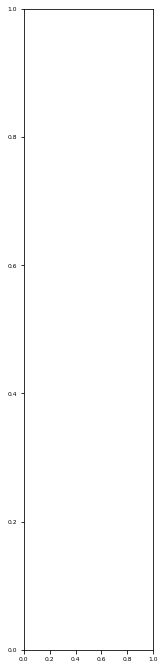